Project description
===

Here we have a dataset on churned Beta Bank customers. We aim to build a model to predict whether a customer will leave the bank soon.

First, we should do some data preprocessing: clean the data, fill in the missing values (if any), and change data types. Next, we need to scale and encode the date. Afterward, we could proceed to develop models.

**Description of the data**
```
/datasets/Churn.csv
Features
    RowNumber — data string index
    CustomerId — unique customer identifier
    Surname — surname
    CreditScore — credit score
    Geography — country of residence
    Gender — gender
    Age — age
    Tenure — period of maturation for a customer’s fixed deposit (years)
    Balance — account balance
    NumOfProducts — number of banking products used by the customer
    HasCrCard — customer has a credit card
    IsActiveMember — customer’s activeness
    EstimatedSalary — estimated salary
Target
    Exited — сustomer has left
```

## Open and prepare the data

In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [2]:
import math
import matplotlib.pyplot as plt 
import numpy as np
import pandas as pd

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier 

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle

In [3]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

pd.set_option('display.float_format', '{:.3f}'.format)
pd.set_option('display.max_colwidth', None) # no wrap
pd.set_option('display.max_columns', 100) # columns number
pd.set_option('display.max_rows', 50) # rows number

In [4]:
churn_dtype = {'CreditScore': 'uint16', 'Age': 'uint8', 'Balance': 'float32', 
                'NumOfProducts': 'uint8', 'HasCrCard': 'uint8', 'IsActiveMember': 'uint8', 
               'EstimatedSalary': 'float32', 'Exited': 'uint8'}

try:
    churn = pd.read_csv('./datasets/Churn.csv', dtype=churn_dtype,)
except:
    churn = pd.read_csv('/datasets/Churn.csv', dtype=churn_dtype,)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CreditScore      10000 non-null  uint16 
 1   Geography        10000 non-null  object 
 2   Gender           10000 non-null  object 
 3   Age              10000 non-null  uint8  
 4   Tenure           10000 non-null  uint8  
 5   Balance          10000 non-null  float32
 6   NumOfProducts    10000 non-null  uint8  
 7   HasCrCard        10000 non-null  uint8  
 8   IsActiveMember   10000 non-null  uint8  
 9   EstimatedSalary  10000 non-null  float32
 10  Exited           10000 non-null  uint8  
dtypes: float32(2), object(2), uint16(1), uint8(6)
memory usage: 312.6+ KB


,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000
mean,650.529,38.922,4.543,76485.891,1.530,0.706,0.515,100090.234,0.204
std,96.653,10.488,3.112,62397.406,0.582,0.456,0.500,57510.492,0.403
min,350.000,18.000,0.000,0.000,1.000,0.000,0.000,11.580,0.000
25%,584.000,32.000,2.000,0.000,1.000,0.000,0.000,51002.109,0.000
50%,652.000,37.000,4.000,97198.539,1.000,1.000,1.000,100193.914,0.000
75%,718.000,44.000,7.000,127644.238,2.000,1.000,1.000,149388.254,0.000
max,850.000,92.000,10.000,250898.094,4.000,1.000,1.000,199992.484,1.000


,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
2124,704,France,Male,32,7,127785.172,4,0,0,184464.703,1
3103,655,France,Female,47,10,0.000,2,1,0,167778.625,0
1919,618,France,Male,56,7,0.000,1,1,1,142400.266,1
1130,571,Germany,Female,34,1,101736.656,1,0,1,195651.656,0
6699,709,France,Female,41,3,150300.656,2,1,0,71672.859,0



Duplicates in data: 0



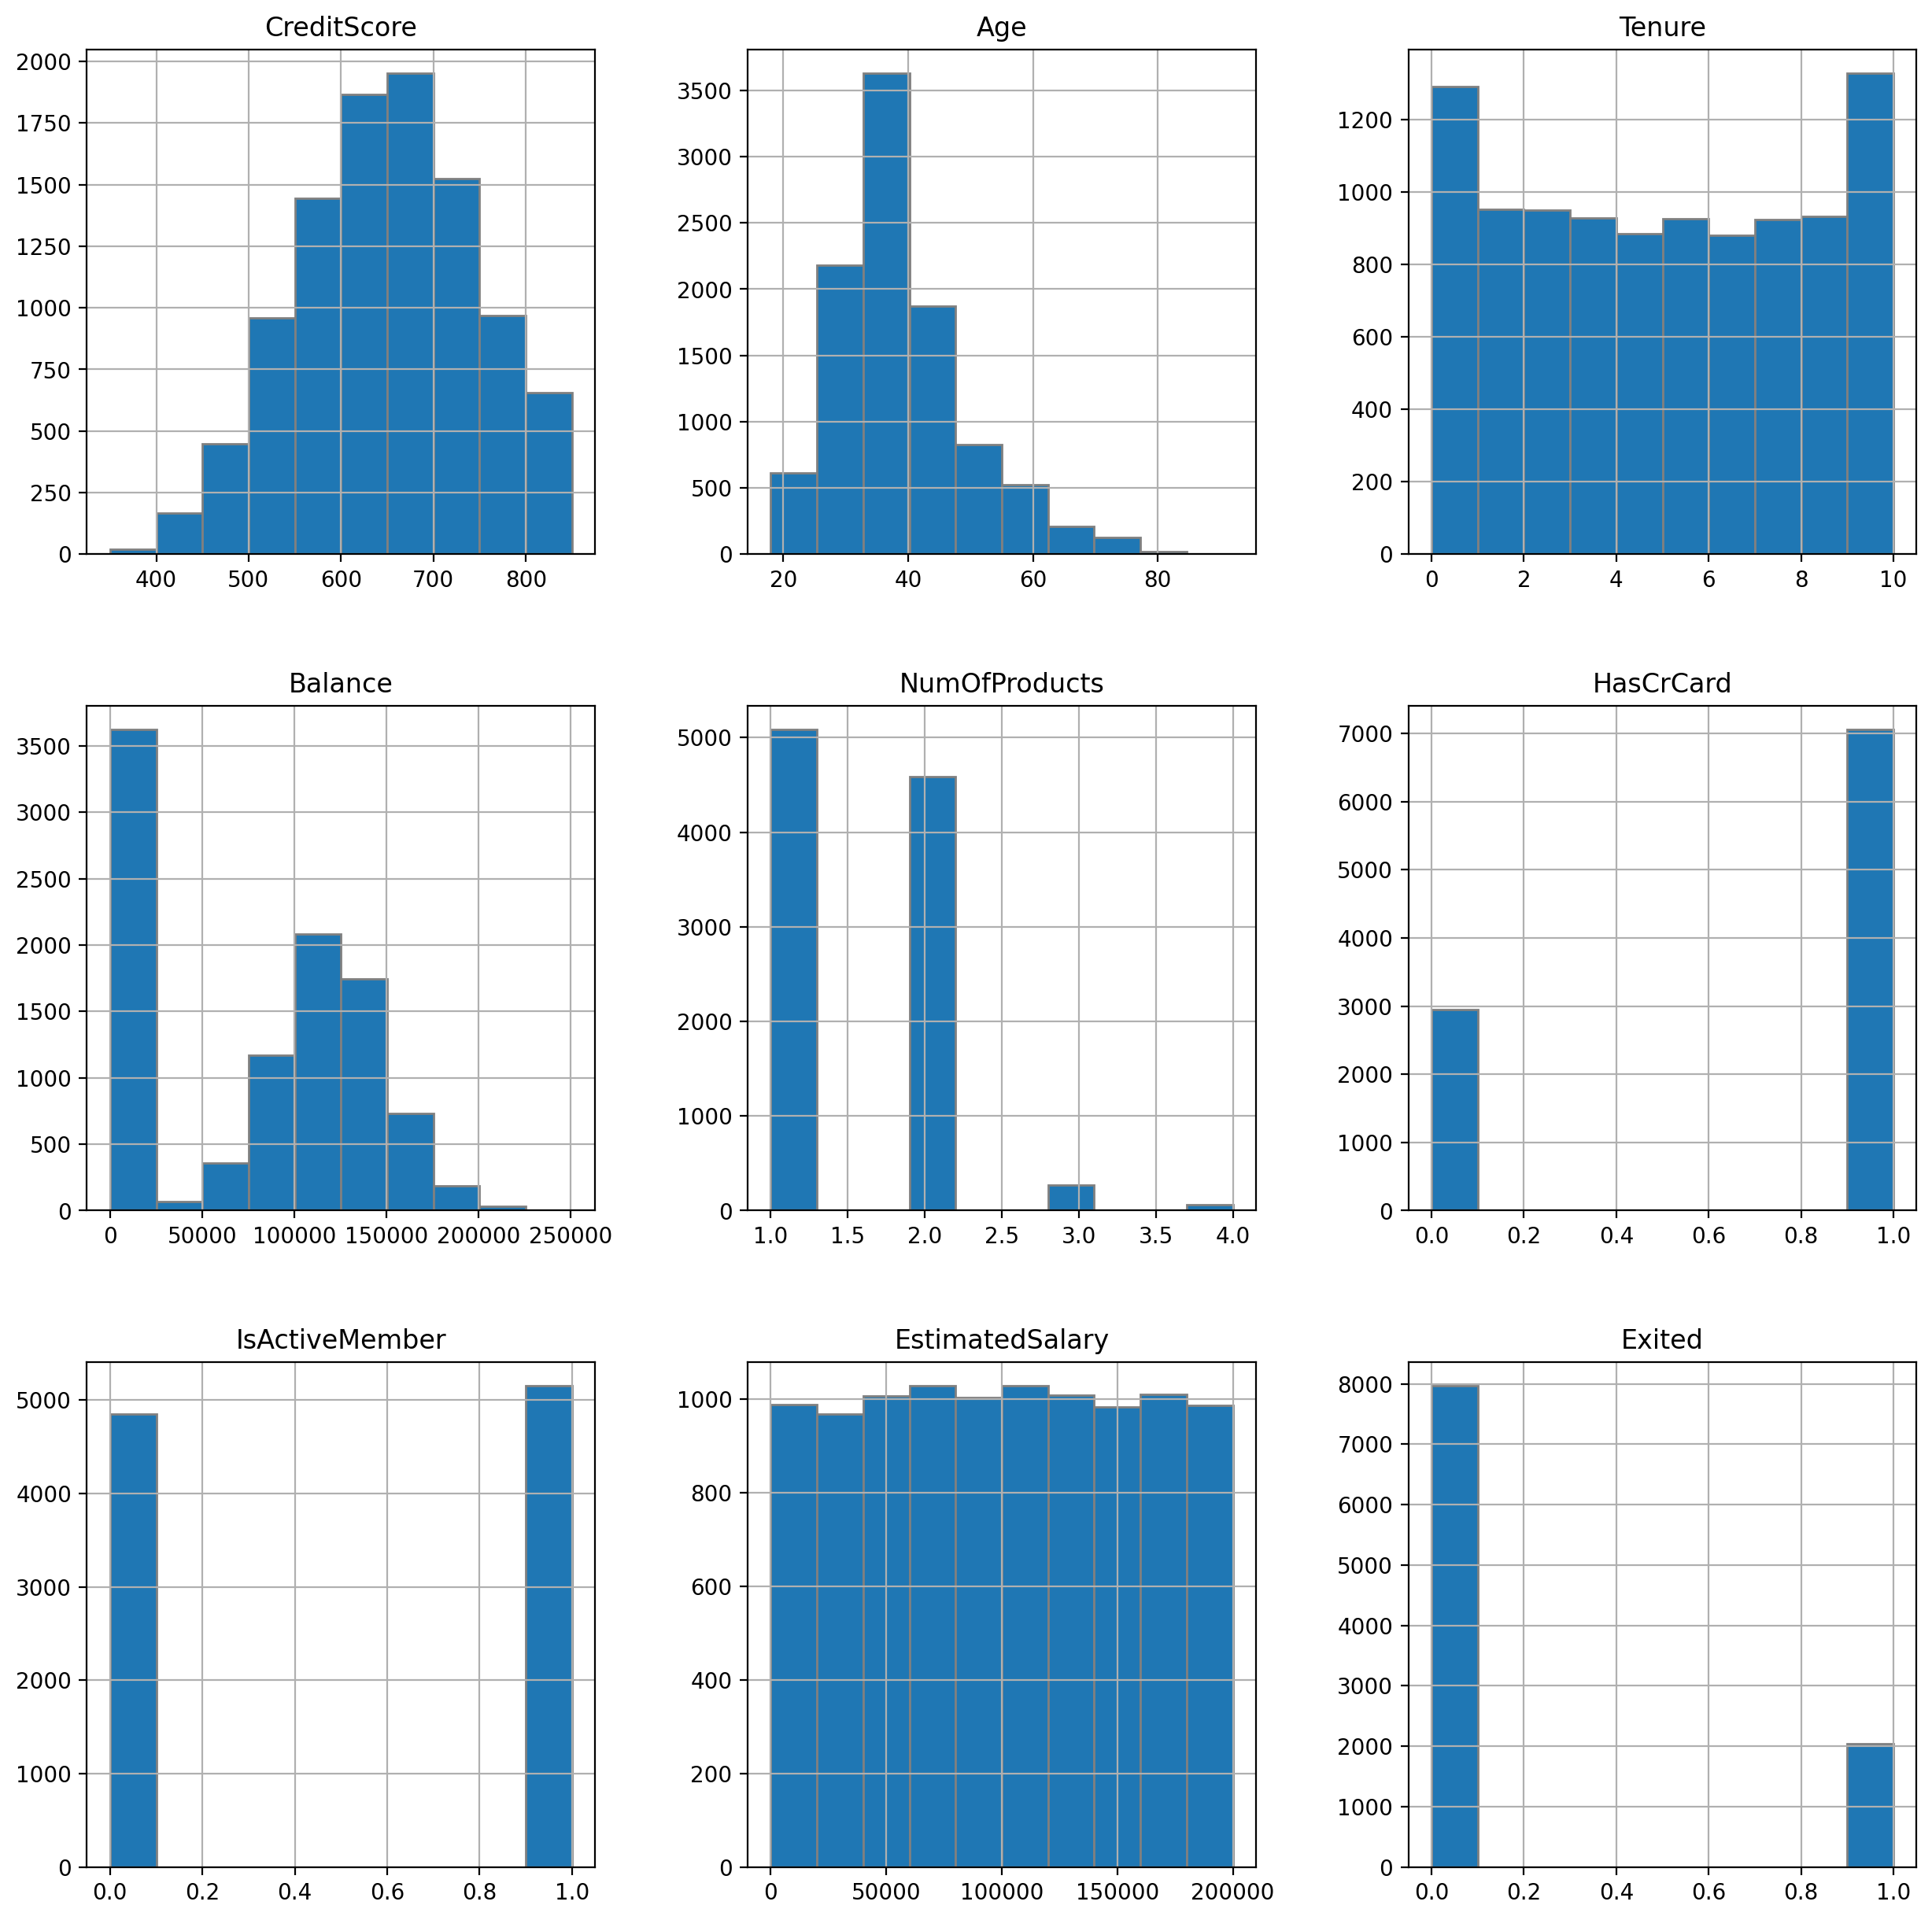

In [5]:
churn.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1, inplace = True)

churn['Tenure'] = pd.to_numeric(churn['Tenure'].fillna(0), downcast='unsigned')

churn.info()
display(churn.describe())
display(churn.sample(5))
print()
print('Duplicates in data: {0}'.format(churn.duplicated().sum()))
print()
churn.hist(figsize=(15,15), edgecolor='gray');

**Conclusion**

There are about 10% missing values in the `Tenure` feature. I suppose they indicate the customers without any deposits, and we could fill them with zero. 
Some features don't influence our target, so we exclude them from the dataset (`RowNumber`, `CustomerId`, `Surname`).
There are no duplicates in this dataset.  
After the first investigation, we've downcasted floats and unsigned while reading from the file.  

## Examine the balance of classes. 

In [6]:
X = churn.drop(['Exited'], axis=1)
y = churn['Exited']

encoder = OrdinalEncoder() 
X = pd.DataFrame(encoder.fit_transform(X), columns=X.columns)

X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42)

X_train_val = X_train_val.copy()
X_train = X_train.copy()
X_val = X_val.copy()
X_test = X_test.copy()

numeric = ['CreditScore', 'Age', 'Tenure', 'Balance', 'EstimatedSalary']
scaler = StandardScaler(copy=True)
scaler.fit(X_train[numeric]);

X_train_val[numeric] = scaler.transform(X_train_val[numeric]);
X_train[numeric] = scaler.transform(X_train[numeric]);
X_val[numeric] = scaler.transform(X_val[numeric]);
X_test[numeric] = scaler.transform(X_test[numeric]);

print('Train set length:', X_train.shape[0])
print()
print('Validation set length:', X_val.shape[0])
print()
print('Test set length:', X_test.shape[0])

Train set length: 6000

Validation set length: 2000

Test set length: 2000


In [7]:
y.value_counts(normalize=True)

0   0.796
1   0.204
Name: Exited, dtype: float64

### DecisionTreeClassifier

In [8]:
dep = 1
f1 = 0
for i in range(1,50):
    model = DecisionTreeClassifier(random_state=42, max_depth=i)
    model.fit(X_train, y_train)
    if f1_score(y_val, model.predict(X_val)) > f1:
        f1 = f1_score(y_val, model.predict(X_val))
        dep = i

print(f'Best depth: {dep}')
model = DecisionTreeClassifier(random_state=42, max_depth=dep)
model.fit(X_train, y_train)
print(f'F1: {f1_score(y_val, model.predict(X_val)):.3f}')       

Best depth: 5
F1: 0.574


The best F1 score (0.574) has the DecisionTreeClassifier with depth of 5.

---
### RandomForestClassifier

In [9]:
n_es = 1
f1 = 0
for i in range(1,50):
    model = RandomForestClassifier(random_state=42, n_estimators=i)
    model.fit(X_train, y_train)
    if f1_score(y_val, model.predict(X_val)) > f1:
        f1 = f1_score(y_val, model.predict(X_val))
        n_es = i

print(f'Best number of estimators: {n_es}')        
model = RandomForestClassifier(random_state=42, n_estimators=n_es)
model.fit(X_train, y_train)
print(f'F1: {f1_score(y_val, model.predict(X_val)):.3f}')        

Best number of estimators: 25
F1: 0.590


The best F1 score (0.59) has the RandomForestClassifier with 25 estimators.

---

**Conclusion**

We have class "0" four times more often than class "1" in this dataset. To improve our models, we need to address this imbalance.

---

## Improve the quality of the model. 
### Balancing with class_weight='balanced' parameter
#### DecisionTreeClassifier

In [10]:
dep = 1
f1 = 0
for i in range(1,10):
    model = DecisionTreeClassifier(random_state=42, max_depth=i, class_weight='balanced')
    model.fit(X_train, y_train)
    if f1_score(y_val, model.predict(X_val)) > f1:
        f1 = f1_score(y_val, model.predict(X_val))
        dep = i

print(f'Best depth: {dep}')
model = DecisionTreeClassifier(random_state=42, max_depth=dep, class_weight='balanced')
model.fit(X_train, y_train)
print(f'F1: {f1_score(y_val, model.predict(X_val)):.3f}')       

Best depth: 5
F1: 0.568


The best F1 score (0.568) has the DecisionTreeClassifier with depth of 5.

---
#### RandomForestClassifier

In [11]:
n_es = 1
f1 = 0
for i in range(1,50):
    model = RandomForestClassifier(random_state=42, n_estimators=i, class_weight='balanced')
    model.fit(X_train, y_train)
    if f1_score(y_val, model.predict(X_val)) > f1:
        f1 = f1_score(y_val, model.predict(X_val))
        n_es = i

print(f'Best number of estimators: {n_es}')        
model = RandomForestClassifier(random_state=42, n_estimators=n_es, class_weight='balanced')
model.fit(X_train, y_train)
print(f'F1: {f1_score(y_val, model.predict(X_val)):.3f}')        

Best number of estimators: 45
F1: 0.589


The best F1 score (0.579) has the RandomForestClassifier with 29 estimators.

---

### Balancing with downsampling

In [12]:
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat([features_zeros.sample(frac=fraction, random_state=42)] + [features_ones])
    target_downsampled = pd.concat([target_zeros.sample(frac=fraction, random_state=42)] + [target_ones])
    features_downsampled, target_downsampled = shuffle(features_downsampled, target_downsampled, random_state=42)

    return features_downsampled, target_downsampled

X_train_down, y_train_down = downsample(X_train, y_train, 0.25)

print('Train set length:', X_train_down.shape[0])
display(y_train_down.value_counts(normalize=True))

Train set length: 2423


1   0.508
0   0.492
Name: Exited, dtype: float64

#### DecisionTreeClassifier

In [13]:
dep = 1
f1 = 0
for i in range(1,10):
    model = DecisionTreeClassifier(random_state=42, max_depth=i)
    model.fit(X_train_down, y_train_down)
    if f1_score(y_val, model.predict(X_val)) > f1:
        f1 = f1_score(y_val, model.predict(X_val))
        dep = i

print(f'Best depth: {dep}')
model = DecisionTreeClassifier(random_state=42, max_depth=dep)
model.fit(X_train_down, y_train_down)
print(f'F1: {f1_score(y_val, model.predict(X_val)):.3f}')       

Best depth: 5
F1: 0.565


The best F1 score (0.565) has the DecisionTreeClassifier with depth of 5.

---
#### RandomForestClassifier

In [14]:
n_es = 1
f1 = 0
for i in range(1,50):
    model = RandomForestClassifier(random_state=42, n_estimators=i)
    model.fit(X_train_down, y_train_down)
    if f1_score(y_val, model.predict(X_val)) > f1:
        f1 = f1_score(y_val, model.predict(X_val))
        n_es = i

print(f'Best number of estimators: {n_es}')        
model = RandomForestClassifier(random_state=42, n_estimators=n_es)
model.fit(X_train_down, y_train_down)
print(f'F1: {f1_score(y_val, model.predict(X_val)):.3f}')        

Best number of estimators: 38
F1: 0.589


The best F1 score (0.589) has the RandomForestClassifier with 38 estimators.

---

### Balancing with upsampling

In [15]:
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    features_upsampled, target_upsampled = shuffle(features_upsampled, target_upsampled, random_state=42)

    return features_upsampled, target_upsampled

X_train_up, y_train_up = upsample(X_train, y_train, 4)

print('Train set length:', X_train_up.shape[0])
display(y_train_up.value_counts(normalize=True))

Train set length: 9693


1   0.508
0   0.492
Name: Exited, dtype: float64

#### DecisionTreeClassifier

In [16]:
dep = 1
f1 = 0
for i in range(1,10):
    model = DecisionTreeClassifier(random_state=42, max_depth=i)
    model.fit(X_train_up, y_train_up)
    if f1_score(y_val, model.predict(X_val)) > f1:
        f1 = f1_score(y_val, model.predict(X_val))
        dep = i

print(f'Best depth: {dep}')
model = DecisionTreeClassifier(random_state=42, max_depth=dep)
model.fit(X_train_up, y_train_up)
print(f'F1: {f1_score(y_val, model.predict(X_val)):.3f}')       

Best depth: 5
F1: 0.568


The best F1 score (0.568) has the DecisionTreeClassifier with depth of 5.

---
#### RandomForestClassifier

In [17]:
n_es = 1
f1 = 0
for i in range(1,50):
    model = RandomForestClassifier(random_state=42, n_estimators=i)
    model.fit(X_train_up, y_train_up)
    if f1_score(y_val, model.predict(X_val)) > f1:
        f1 = f1_score(y_val, model.predict(X_val))
        n_es = i

print(f'Best number of estimators: {n_es}')        
model = RandomForestClassifier(random_state=42, n_estimators=n_es)
model.fit(X_train_up, y_train_up)
print(f'F1: {f1_score(y_val, model.predict(X_val)):.3f}')        

Best number of estimators: 35
F1: 0.616


The best F1 score (0.616) has the RandomForestClassifier with 35 estimators.

---

**Conclusion**

Upsampling gives the best result than the class_weight='balanced' parameter or downsampling.  
And best model overll is the **RandomForestClassifier with 35 estimators.**

---

## Perform the final testing.

In [18]:
X_train_val_up, y_train_val_up = upsample(X_train_val, y_train_val, 4)
print('Train set length:', X_train_up.shape[0])
display(y_train_up.value_counts(normalize=True))


model = RandomForestClassifier(random_state=42, n_estimators=35)
model.fit(X_train_val_up, y_train_val_up)

print(f'F1: {f1_score(y_test, model.predict(X_test)):.3f}')  
print(f'AUC-ROC: {roc_auc_score(y_test, model.predict_proba(X_test)[:, 1]):.3f}')  

Train set length: 9693


1   0.508
0   0.492
Name: Exited, dtype: float64

F1: 0.595
AUC-ROC: 0.844


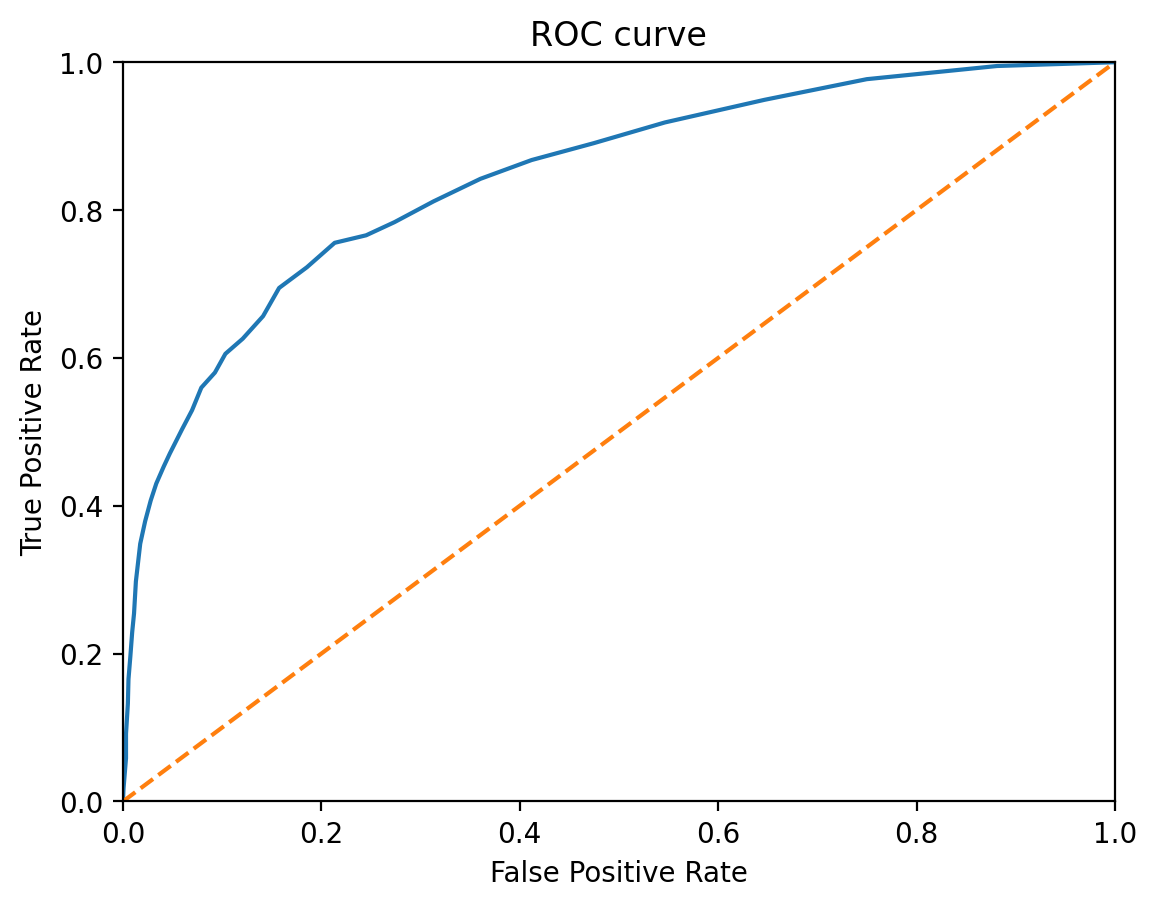

In [19]:
fpr, tpr, thresholds = roc_curve(y_test,  model.predict_proba(X_test)[:, 1])

plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.show()

**Conclusion**

After training our best model on the entire source dataset (train and validation combined and downsampled), we have a 0.595 F1 score and 0.844 AUC-ROC metric on the test dataset.

---

## Overall conclusion

Using some data on churned Beta Bank customers, we built a DecisionTreeClassifier that predicts the best option with an F1 score of 0.595 and an AUC-ROC metric of 0.844.